In [12]:
# Make sure you have the choice-learn package installed
# pip install choice-learn
from choice_learn.datasets import load_car_preferences

In [13]:
import os
import sys

sys.path.append("../python")

import matplotlib.pyplot as plt
import numpy as np

In [14]:
from models import HeuristicModel
import metrics

In [15]:
df = load_car_preferences(as_frame=True)

In [16]:
df.head()

,rownames,choice,college,hsg2,coml5,type1,type2,type3,type4,type5,...,cost3,cost4,cost5,cost6,station1,station2,station3,station4,station5,station6
0,1,choice1,0,0,0,van,regcar,van,stwagon,van,...,6,6,8,8,0.1,0.1,0.3,0.3,1.0,1.0
1,2,choice2,1,1,1,regcar,van,regcar,stwagon,regcar,...,8,8,4,4,0.0,0.0,0.1,0.1,1.0,1.0
2,3,choice5,0,1,0,regcar,truck,regcar,van,regcar,...,8,8,2,2,0.1,0.1,0.3,0.3,1.0,1.0
3,4,choice5,0,0,1,regcar,truck,regcar,van,regcar,...,2,2,4,4,0.0,0.0,0.7,0.7,0.1,0.1
4,5,choice5,0,1,0,regcar,truck,regcar,van,regcar,...,8,8,2,2,0.3,0.3,0.7,0.7,1.0,1.0


### Columns Description:

| Column Name    | Description |
| -------- | ------- |
| choice | Choice of a vehicle among 6 propositions |
| college | College education of customer |
| hsg2 | Size of household is greater than 2 |
| coml5 | Customer commutes less than 5 miles a day |

Then each alternive has several attributes:
| Column Name    | Description |
| -------- | ------- |
| type  | Body type of alternative Z, one of regcar (regular car), sportuv (sport utility vehicle), sportcar, stwagon (station wagon), truck, van |
| fuel | Fuel type: among gasoline, methanol, cng (compressed natural gas), electric. |
| price | Price of vehicle divided by the logarithm of income|
| range | Hundreds of miles vehicle can travel between refuelings/rechargings |
| acc | Acceleration, tens of seconds required to reach 30 mph from stop |
| speed | Highest attainable speed in hundreds of mph|
| pollution | Tailpipe emissions as fraction of those for new gas vehicle|
| size | 0 for a mini, 1 for a subcompact, 2 for a compact and 3 for a mid–size or large vehicle|
| space | Fraction of luggage space in comparable new gas vehicle |
| cost | Cost per mile of travel (tens of cents) |
| station | Fraction of stations that can refuel/recharge vehicle |

In [17]:
import pandas as pd
import numpy as np

# Define only numerical features that influence preferences
numerical_features = ["price", "range", "acc", "speed", "pollution", "size", "space", "cost", "station"]

preference_pairs = []

for _, row in df.iterrows():
    chosen_col = row["choice"] 
    
    chosen_index = int(chosen_col.replace("choice", "")) - 1  # Convert "choice1" → index 0
    
    # Extract only numerical features for the chosen car
    X = row[[f"{col}{chosen_index + 1}" for col in numerical_features]].values  
    
    # Iterate over rejected alternatives
    for alt_index in range(6):  # Assuming 6 alternatives per customer
        if alt_index != chosen_index:
            # Extract only numerical features for the rejected alternative
            Y = row[[f"{col}{alt_index + 1}" for col in numerical_features]].values
            preference_pairs.append((X, Y))

print(X)  # Check chosen car numerical features
print(Y)  # Check rejected car numerical features



[5.1388859 75 2.5 85 0.4 3 1.0 2 0.3]
[4.1753448 350 4.0 110 0.25 2 1 6 1.0]


In [18]:
X_data = np.array([pair[0] for pair in preference_pairs])  # Chosen cars
Y_data = np.array([pair[1] for pair in preference_pairs])  # Rejected cars

print(f"Extracted {X_data.shape[0]} preference pairs.")
print(X_data, Y_data)


Extracted 23270 preference pairs.
[[4.1753448 250 4.0 ... 0.7 4 0.1]
 [4.1753448 250 4.0 ... 0.7 4 0.1]
 [4.1753448 250 4.0 ... 0.7 4 0.1]
 ...
 [5.1388859 75 2.5 ... 1.0 2 0.3]
 [5.1388859 75 2.5 ... 1.0 2 0.3]
 [5.1388859 75 2.5 ... 1.0 2 0.3]] [[4.1753448 250 4.0 ... 0.7 4 0.1]
 [4.8177056 400 6.0 ... 1.0 6 0.3]
 [4.8177056 400 6.0 ... 1.0 6 0.3]
 ...
 [5.1388859 75 2.5 ... 1.0 2 0.3]
 [4.1753448 350 4.0 ... 1 6 1.0]
 [4.1753448 350 4.0 ... 1 6 1.0]]


In [19]:
# Let's train an example model
X, Y = X_data, Y_data
model = HeuristicModel(n_pieces=5, n_clusters=2) # Instantiation of the model with hyperparameters, if needed
model.fit(X, Y) # Training of the model, using preference data

In [20]:
# First, let's see how our model reconsiders our preferences
# Our data preferences were X[i] >> Y[i] for all i, let's see if our model agrees
print((model.predict_utility(X) - model.predict_utility(Y))[:5]) # Preferred item has a higher utility

# predict_utility returns utility of samples for each cluster, returning shape (n_samples, n_clusters)

[[ 0.          0.        ]
 [-0.0216199  -0.07972572]
 [-0.0216199  -0.07972572]
 [-0.02443548 -0.13264134]
 [-0.02443548 -0.13264134]]


In [21]:

# Predict utility values
utility_values = model.predict_utility(X)
print(utility_values)

[[1.00468228 0.62789078]
 [1.00468228 0.62789078]
 [1.00468228 0.62789078]
 ...
 [0.88603369 0.80297343]
 [0.88603369 0.80297343]
 [0.88603369 0.80297343]]


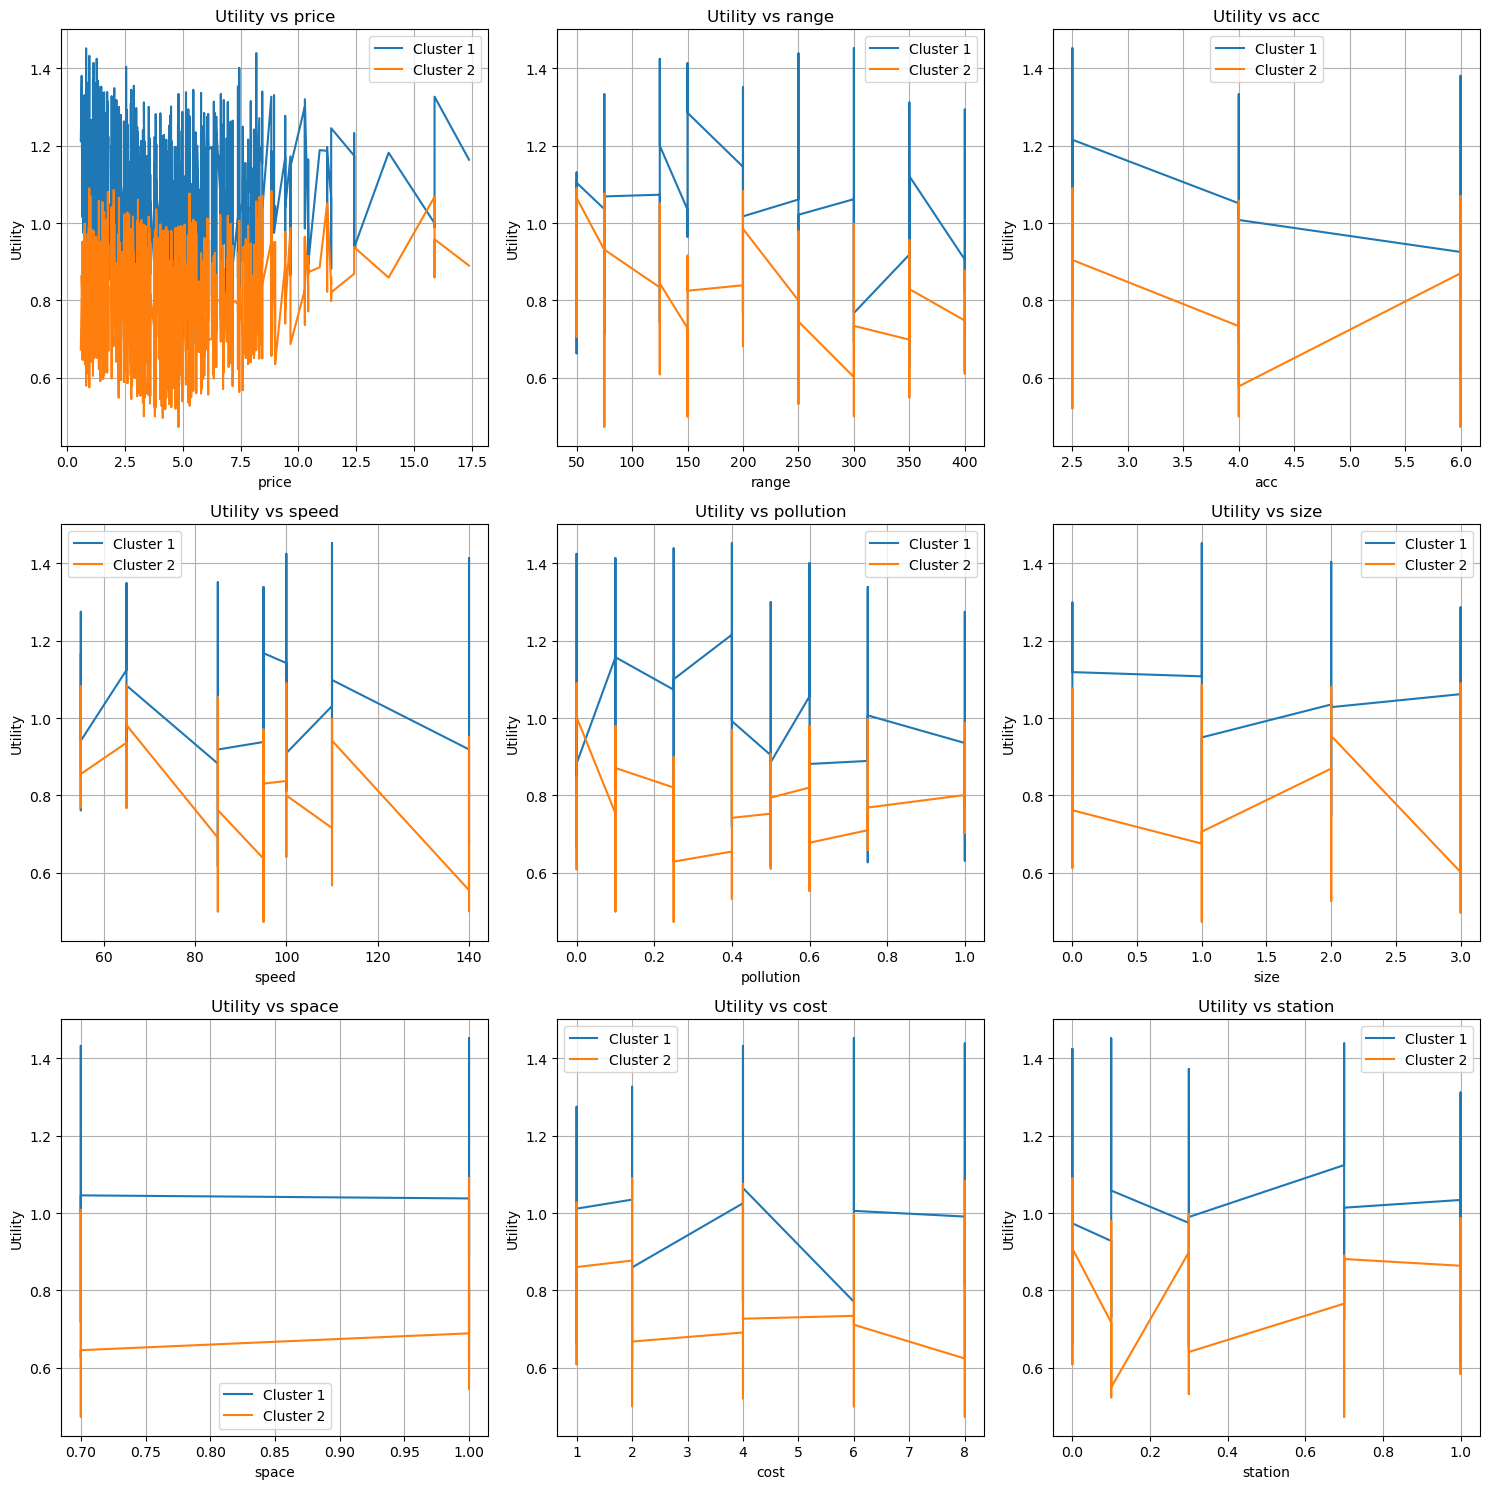

In [24]:
# Create a figure with subplots for each feature
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

# For each feature
for idx, feature in enumerate(numerical_features):
    # Extract the feature values
    feature_values = X[:, idx]
    
    # Sort values and utilities by feature values
    sorted_indices = np.argsort(feature_values)
    sorted_features = feature_values[sorted_indices]
    sorted_utilities = utility_values[sorted_indices]
    
    # Plot for each cluster
    for cluster in range(utility_values.shape[1]):
        axes[idx].plot(sorted_features, sorted_utilities[:, cluster], 
                      label=f'Cluster {cluster+1}')
    
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Utility')
    axes[idx].set_title(f'Utility vs {feature}')
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

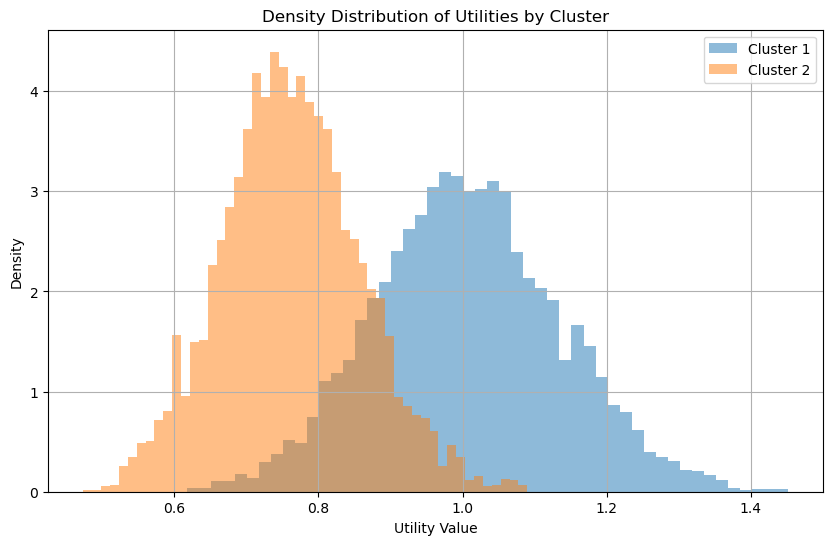

In [25]:
# Create density plot of utilities for both clusters
plt.figure(figsize=(10, 6))

# Plot density for each cluster
for i in range(utility_values.shape[1]):
    plt.hist(utility_values[:, i], bins=50, density=True, alpha=0.5, 
             label=f'Cluster {i+1}')

plt.xlabel('Utility Value')
plt.ylabel('Density')
plt.title('Density Distribution of Utilities by Cluster')
plt.legend()
plt.grid(True)
plt.show()